### Notebook de test des GNNs sur des Toys Examples : 

In [2]:
import sys
import numpy as np
sys.path.append('../datasets')
from datasets.manager import IMDBBinary, DD
import torch 

from utils.utils import visualise_graph, get_adjacency_and_features
from src.gnn import GNNClassifier

In [3]:
IMDB = IMDBBinary()
DD = DD()

#### **Visualisation du dataset**

In [4]:
x_IMBD, y_IMDB = IMDB.dataset.get_data(), IMDB.dataset.get_targets()

In [5]:
node8 = x_IMBD[8]
node8

GraphData(x=torch.Size([18, 1]), edge_index=torch.Size([2, 153]))

`GraphData(x=torch.Size([18, 1]), edge_index=torch.Size([2, 153]))` refers to a graph that has: 
- 18 nodes, each having features of dimension 1
- 153 edges (each between 2 nodes)

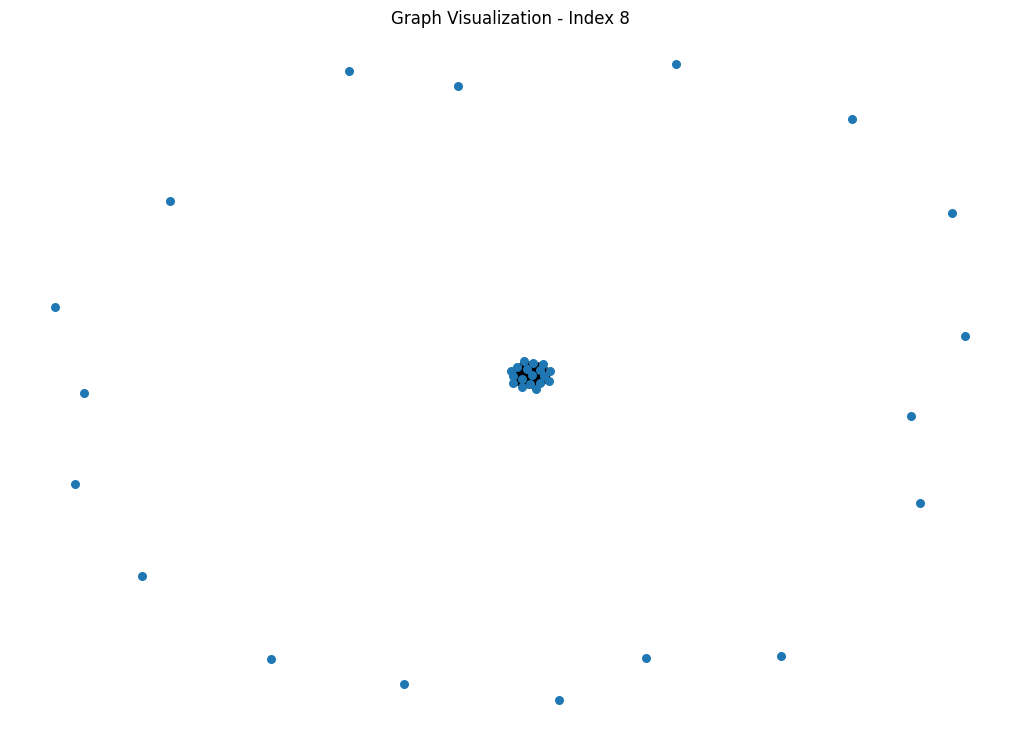

In [6]:
visualise_graph(8, x_IMBD)

The adjency matrix of such a graph is computed by `get_adjacency_and_features` and given by:

In [7]:
adjency_mat, feature_vect = get_adjacency_and_features(node8)
print("Adjency matrix:\n")
print(adjency_mat)
print("Feature vector: \n")
print(feature_vect)

Adjency matrix:

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],

In [8]:
model = GNNClassifier(in_features=1, 
                      embedding_dim=1, 
                      out_features=1, 
                      num_layers=3)

out = model(feature_vect, adjency_mat)

out 

tensor([ 0.1691, -0.7365], grad_fn=<ViewBackward0>)